In [19]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

```
FalconForCausalLM(
  (transformer): FalconModel(
    (word_embeddings): Embedding(50304, 2048)
    (h): ModuleList(
      (0-23): 24 x FalconDecoderLayer(
        (self_attention): FalconAttention(
          (query_key_value): FalconLinear(in_features=2048, out_features=6144, bias=True)
          (dense): FalconLinear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): FalconMLP(
          (dense_h_to_4h): FalconLinear(in_features=2048, out_features=8192, bias=True)
          (act): GELU(approximate='none')
          (dense_4h_to_h): FalconLinear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
      )
    )
    (ln_f): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=2048, out_features=50304, bias=False)
)
```

In [ ]:
# project the path1_points to two dimensions using pca in pytorch using svd
_,S1,V1 = torch.svd_lowrank(path1_points, q=100)
_,S2,V2 = torch.svd_lowrank(path2_points, q=100)

In [20]:
# These are the path1 and path2 of some particular transformer in the ModuleList
# The hidden state before the transformer before the transformer does its transformation
path1 = torch.load('..//scripts/data/outputs_0_6.pt')
# The hidden state after the transformation
path2 = torch.load('..//scripts/data/inputs_0_7.pt')

In [21]:
# Need to remember this for late
path1.shape

torch.Size([4, 116, 2048])

In [52]:
print(torch.norm(path1[0][0] - path2[0][0]))

tensor(43.3627, device='cuda:0')


In [54]:
print(path1[0][1])
print(path2[0][1])

tensor([ 0.1193, -0.0696, -0.0138,  ...,  0.0014,  0.0849, -0.0243],
       device='cuda:0')
tensor([ 0.8726,  0.0347, -1.0067,  ...,  1.6523,  0.0993, -0.4386],
       device='cuda:0')


In [22]:
print(f'Number of paths:       {path1.shape[0]}')
print(f'Length of path:        {path1.shape[1]}')
print(f'Dim of points on path: {path1.shape[2]}')
number_of_paths = path1.shape[0]
length_of_path = path1.shape[1]
dim_of_points_on_path = path1.shape[2]

Number of paths:       4
Length of path:        116
Dim of points on path: 2048


In [23]:
# Remove the first entry of the path
path1 = path1[:, 1:, :]
path2 = path2[:, 1:, :]

In [48]:
# Flatten the data into just a list of points
path1_points = path1.reshape(-1, 2048)
path2_points = path2.reshape(-1, 2048)

In [49]:
# Make sure that the flattening works as expected
torch.norm(path1[2, 7, :] - path1_points.reshape(number_of_paths, length_of_path-1, -1)[2, 7, :])

tensor(0., device='cuda:0')

In [50]:
# project the path1_points to two dimensions using pca in pytorch using svd
_,S1,V1 = torch.svd_lowrank(path1_points, q=100)
_,S2,V2 = torch.svd_lowrank(path2_points, q=100)

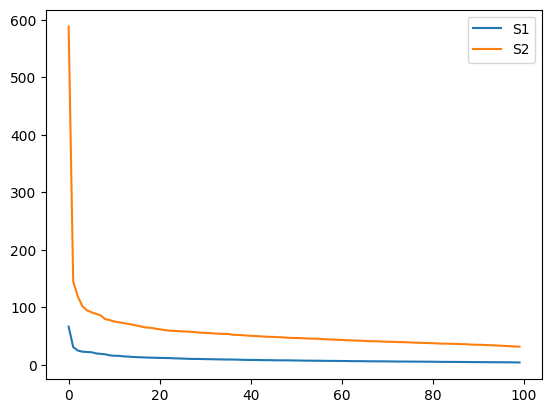

In [51]:
plt.plot(S1.cpu(), label='S1')
plt.plot(S2.cpu(), label='S2')
plt.legend()

In [ ]:
# project the input points to two dimensions
path1_points_2d = torch.matmul(path1_points, V[:,:2]) 
path2_points_2d = torch.matmul(path2_points, V[:,:2]) 

In [26]:
# Whiten the data
path1_points = (path1_points - path1_points.mean(dim=0, keepdim=True))/path1_points.std(dim=0, keepdim=True)
path2_points = (path2_points - path2_points.mean(dim=0, keepdim=True))/path2_points.std(dim=0, keepdim=True)

In [27]:
# Try to make the input and the output as close as possible  
# XW=Y
X = path1_points
Y = path2_points
W = torch.inverse(X.T @ X) @ X.T @ Y 

In [28]:
torch.norm(X-Y)

tensor(1203.1552, device='cuda:0')

In [29]:
X = X @ W

In [30]:
torch.norm(X - Y)

tensor(49234.4922, device='cuda:0')

In [32]:

# project the input points to two dimensions
path1_points_2d = torch.matmul(X, V[:,:2]) 
path2_points_2d = torch.matmul(Y, V[:,:2]) 

In [33]:
# Ok, now go back to the original shapes for plotting
path1_points_2d = path1_points_2d.reshape(number_of_paths, length_of_path-1, -1).cpu()
path2_points_2d = path2_points_2d.reshape(number_of_paths, length_of_path-1, -1).cpu()

In [34]:
?plt.quiver

Signature: plt.quiver(*args, data=None, **kwargs) -> 'Quiver'
Docstring:
Plot a 2D field of arrows.

Call signature::

  quiver([X, Y], U, V, [C], **kwargs)

*X*, *Y* define the arrow locations, *U*, *V* define the arrow directions, and
*C* optionally sets the color.

**Arrow length**

The default settings auto-scales the length of the arrows to a reasonable size.
To change this behavior see the *scale* and *scale_units* parameters.

**Arrow shape**

The arrow shape is determined by *width*, *headwidth*, *headlength* and
*headaxislength*. See the notes below.

**Arrow styling**

Each arrow is internally represented by a filled polygon with a default edge
linewidth of 0. As a result, an arrow is rather a filled area, not a line with
a head, and `.PolyCollection` properties like *linewidth*, *edgecolor*,
*facecolor*, etc. act accordingly.


Parameters
----------
X, Y : 1D or 2D array-like, optional
    The x and y coordinates of the arrow locations.

    If not given, they will be genera

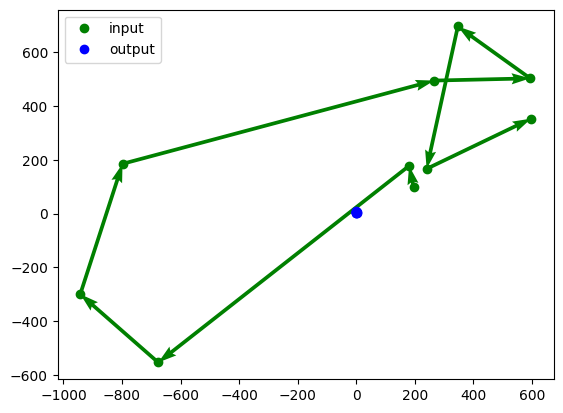

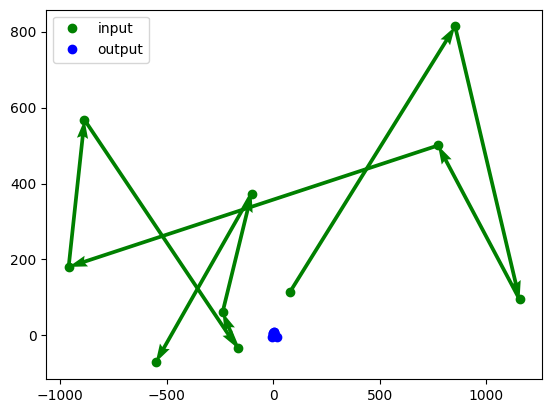

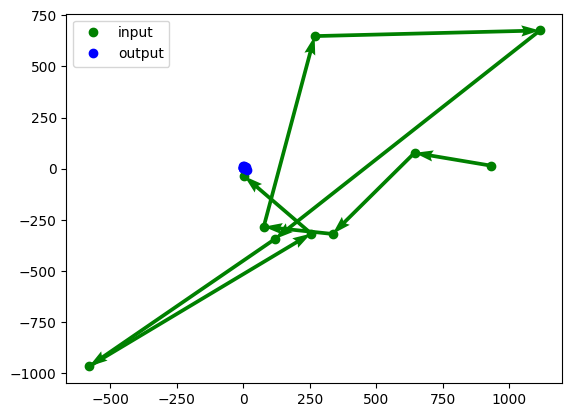

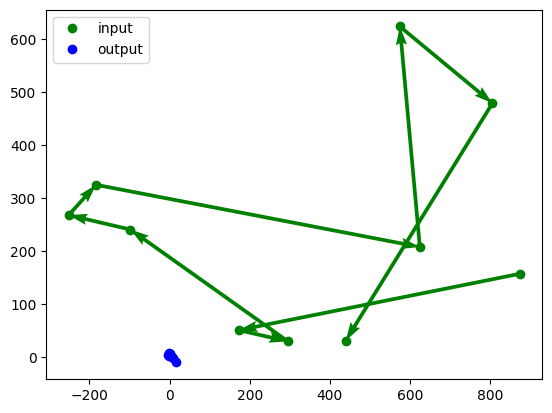

In [35]:
plot_range = torch.arange(0,10)
for i in range(4):
    plt.plot(path1_points_2d[i, plot_range, 0], 
             path1_points_2d[i, plot_range, 1], 
             'o', color='g', label='input')
    x = path1_points_2d[i, plot_range, 0]
    y = path1_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='g', angles='xy', scale_units='xy', scale=1)

    plt.plot(path2_points_2d[i, plot_range ,0], 
             path2_points_2d[i, plot_range, 1], 
             'o', color='b', label='output')
    x = path2_points_2d[i, plot_range, 0]
    y = path2_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='b', angles='xy', scale_units='xy', scale=1)


    plt.legend()
    plt.show()


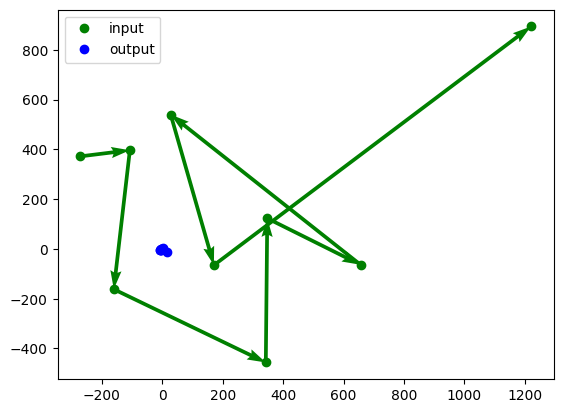

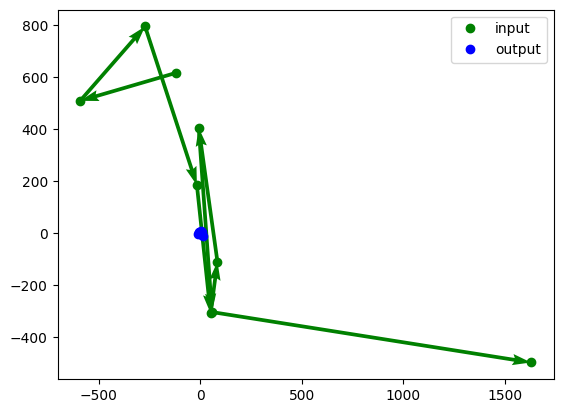

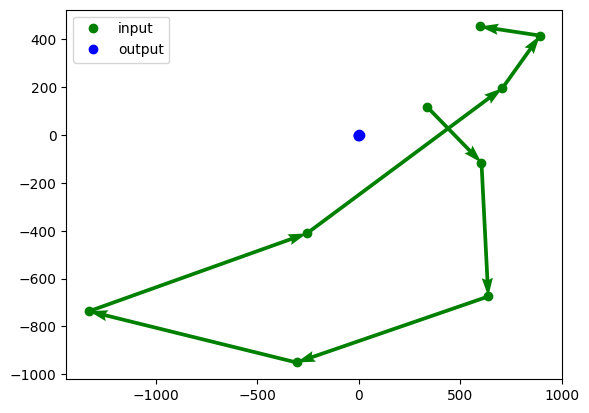

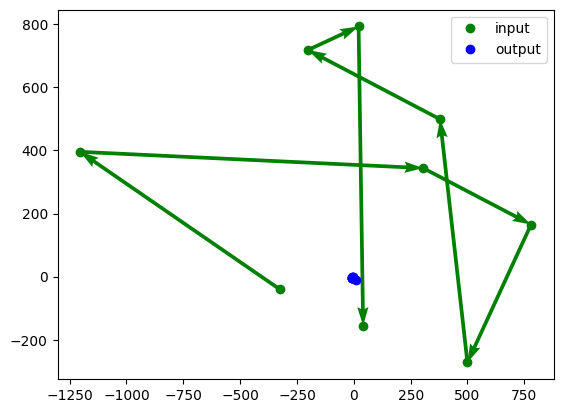

In [36]:
plot_range = torch.arange(106,115)
for i in range(4):
    plt.plot(path1_points_2d[i, plot_range, 0], 
             path1_points_2d[i, plot_range, 1], 
             'o', color='g', label='input')
    x = path1_points_2d[i, plot_range, 0]
    y = path1_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='g', angles='xy', scale_units='xy', scale=1)

    plt.plot(path2_points_2d[i, plot_range ,0], 
             path2_points_2d[i, plot_range, 1], 
             'o', color='b', label='output')
    x = path2_points_2d[i, plot_range, 0]
    y = path2_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='b', angles='xy', scale_units='xy', scale=1)


    plt.legend()
    plt.show()


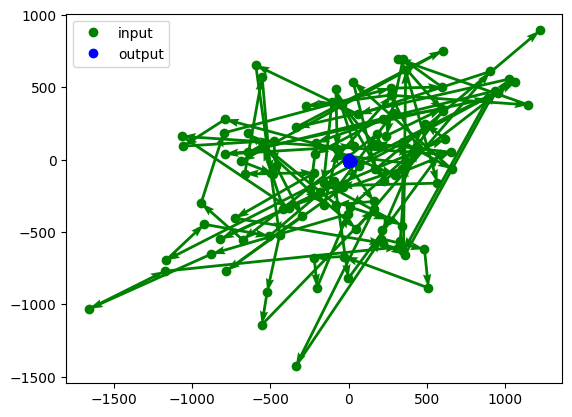

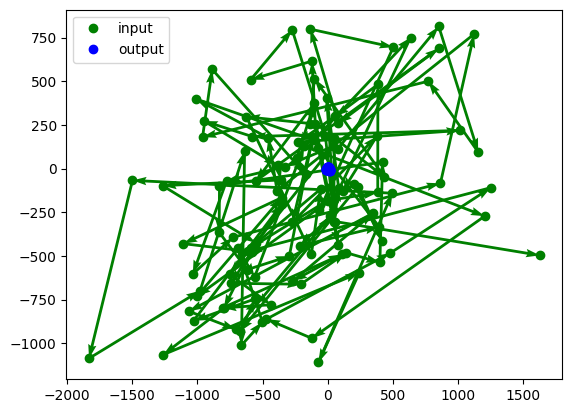

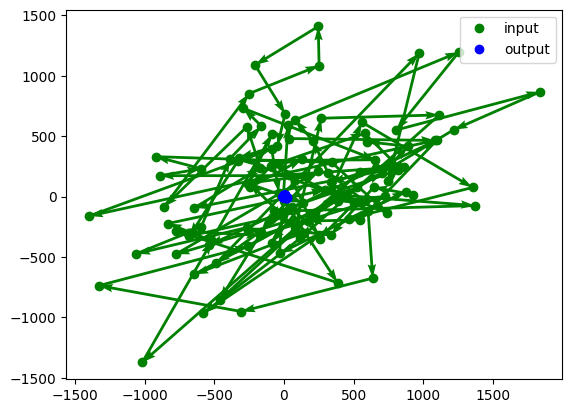

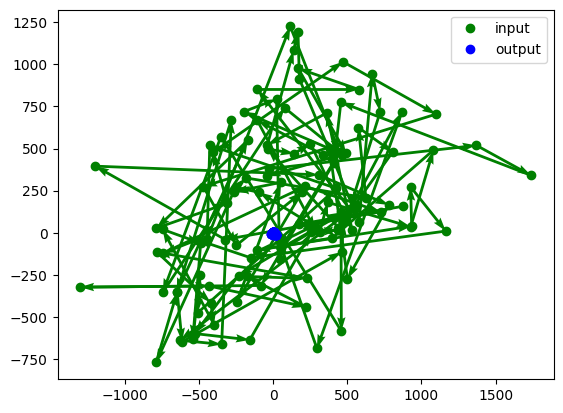

In [37]:
plot_range = torch.arange(0,115)
for i in range(4):
    plt.plot(path1_points_2d[i, plot_range, 0], 
             path1_points_2d[i, plot_range, 1], 
             'o', color='g', label='input')
    x = path1_points_2d[i, plot_range, 0]
    y = path1_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='g', angles='xy', scale_units='xy', scale=1)

    plt.plot(path2_points_2d[i, plot_range ,0], 
             path2_points_2d[i, plot_range, 1], 
             'o', color='b', label='output')
    x = path2_points_2d[i, plot_range, 0]
    y = path2_points_2d[i, plot_range, 1]
    plt.quiver(x[:-1], y[:-1],x[1:]-x[:-1], y[1:]-y[:-1], 
               color='b', angles='xy', scale_units='xy', scale=1)


    plt.legend()
    plt.show()
